<a href="https://colab.research.google.com/github/manuelcozar55/LexAIcon/blob/main/LexAIcon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

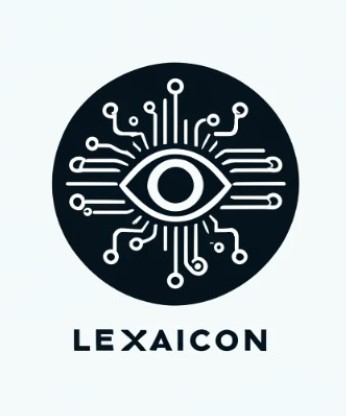

### LexAIcon: Traduce, resume y explica tus textos legales.

Primero se instalan los diferentes elementos necesarios, se realizan los imports y se conecta con la API de Huggingface y a Google Drive

In [ ]:
!pip -q install transformers sentencepiece PyPDF2 python-docx torch faiss-cpu huggingface_hub langchain langchain_community accelerate sentence-transformers langchain-huggingface
!pip -q install -i https://pypi.org/simple/ bitsandbytes

from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, AutoConfig, AutoModelForSequenceClassification, BitsAndBytesConfig
from langchain_community.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA,LLMChain
from langchain_huggingface import HuggingFaceEmbeddings
from PyPDF2 import PdfReader
from docx import Document
import csv
import json
import torch
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from huggingface_hub import login
from google.colab import userdata
from google.colab import drive

token=userdata.get('HF_API')

login(token)

drive.mount('/content/Mydrive/')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.1/405.1 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9

A continuación se configura el modelo LLM y todo lo necesario para su correcto funcionamiento.

In [ ]:
# Configurar modelo y tokenizador
model_name = 'Equall/Saul-7B-Instruct-v1'

# Configuracion para priorizar el uso de GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map = 'auto')
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, device_map = 'auto')

#Configuracion para utilizar RAM
#model = AutoModelForCausalLM.from_pretrained(model_name)
#tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


text_generation_pipeline = pipeline(
    model=model_name,
    tokenizer=tokenizer,
    task="text-generation",
    repetition_penalty=1.1,
    return_full_text=True,
    max_new_tokens=1000,
    device_map='auto',
)

prompt_template = """
### [INST]
Instrucción: Responda a la pregunta basándose en su conocimiento y en el contexto proporcionado. Asegúrese de que la respuesta sea precisa y detallada, conservando el significado original y utilizando terminología legal adecuada.

### CONTEXTO:
{context}

### PREGUNTA:
{question}
[/INST]
"""

saul_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

# Crear el prompt desde la plantilla de prompt
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

# Crear la cadena LLM
llm_chain = LLMChain(llm=saul_llm, prompt=prompt)

cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

<ipython-input-2-ff5cf2df35d8>:40: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  saul_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)
<ipython-input-2-ff5cf2df35d8>:49: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  llm_chain = LLMChain(llm=saul_llm, prompt=prompt)


\En la siguiente sección podemos encontrar todos los componentes necesarios par la clasificación.

In [ ]:
# Cargar modelo clasificador de Huggingface
#def load_classification_model():
 #   tokenizer = AutoTokenizer.from_pretrained("mrm8488/legal-longformer-base-8192-spanish")
  #  model = AutoModelForSequenceClassification.from_pretrained("mrm8488/legal-longformer-base-8192-spanish")
   # return model, tokenizer

# Cargar modelo clasificacdor entrenado
def load_classification_model():
  #Ruta a los archivos de modelo con fine tunning
  model_path = '/content/Mydrive/MyDrive/LexAIcon/MLM_Fine_tunned'
  #Cargar el tokenizer
  tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
  #Cargar el modelo usando el archivo safetensors
  model = AutoModelForSequenceClassification.from_pretrained(model_path, from_tf=False, from_flax=False, torch_dtype=None, use_safetensors=True)
  return model, tokenizer

# Cargar modelo de clasificación
classification_model, classification_tokenizer = load_classification_model()

# Establecer etiquetas para cada tipo dentro de la clasificación
id2label = {0: "multas", 1: "politicas_de_privacidad", 2: "contratos", 3: "denuncias", 4: "otros"}

# Función clasificadora
def classify_text(text):
    inputs = classification_tokenizer(text, return_tensors="pt", max_length=4096, truncation=True, padding="max_length")
    classification_model.eval()
    with torch.no_grad():
        outputs = classification_model(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax(dim=-1).item()
    predicted_label = id2label[predicted_class_id]
    return predicted_label

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/Mydrive/MyDrive/LexAIcon/MLM_Fine_tunned and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.

En la siguiente sección tenemos el codigo de las tres funcionalidades, resumen traduccion y explicación que consiste en una clasificación y preguntas a un documento con el contexto mas relevante gracias a la comparacion de embeddings de la query del usuario y el documento de preguntas y respuesta procesado.

In [ ]:
# Función para cargar documentos JSON
def load_json_documents(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        json_data = json.load(file)
    documents = [{"page_content": entry["question"] + " " + entry["answer"]} for entry in json_data["questions_and_answers"]]
    return documents

# Configuración de FAISS (base de datos vectorial) y embeddings
def create_vector_store(docs):
    #modelPath = "nlpaueb/legal-bert-base-uncased"
    modelPath= "sentence-transformers/all-MiniLM-L6-v2"
    model_kwargs = {'device': 'cpu'}
    encode_kwargs = {'normalize_embeddings': False}

    embeddings = HuggingFaceEmbeddings(
        model_name=modelPath,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs
    )

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
    split_docs = []
    for doc in docs:
        split_docs.extend([{"page_content": fragment} for fragment in text_splitter.split_text(doc["page_content"])])

    vector_store = FAISS.from_texts([doc["page_content"] for doc in split_docs], embedding=embeddings)
    return vector_store

# Función para extraer la respuesta después de [/INST]
def extract_answer(text):
    inst_marker = '[/INST]'
    if inst_marker in text:
        return text.split(inst_marker)[-1].strip()
    return text.strip()

# Función personalizada para imprimir con formato mejorado
def print_formatted_response(title, response):
    separator = "=" * 60
    # Asegurarnos de que los campos existen en la respuesta
    context = response.get("context", "")
    question = response.get("question", "No se proporcionó una pregunta.")
    raw_answer = response.get("text", "No se proporcionó una respuesta.")

    # Extraer la respuesta correcta
    answer = extract_answer(raw_answer)

    # Imprimir Título de la Operación (Explicación, Traducción, Resumen)
    print(f"\n{separator}\n{title}\n{separator}")

    # Imprimir Pregunta
    print(f"\nPregunta:\n{question}\n{separator}")

    # Imprimir Respuesta
    print(f"\nRespuesta:\n{answer}\n{separator}")

def print_formatted_response2(title, response):
    separator = "=" * 60

    # Asegurarnos de que los campos existen en la respuesta
    question = response.get("query", "No se proporcionó una pregunta.")  # Cambié a 'query' ya que parece ser el campo correcto
    raw_answer = response.get("result", "No se proporcionó una respuesta.")  # Cambié a 'result' ya que parece ser el campo correcto

    # Extraer la respuesta correcta
    answer = extract_answer(raw_answer)

    # Imprimir Título de la Operación (Explicación, Traducción, Resumen)
    print(f"\n{separator}\n{title}\n{separator}")

    # Imprimir Pregunta
    print(f"\nPregunta:\n{question}\n{separator}")

    # Imprimir Respuesta
    print(f"\nRespuesta:\n{answer}\n{separator}")

# Función para traducir texto
def translate(text, target_language):
    context = "Eres un experto traductor de textos legales."
    question = f"Por favor, traduzca el siguiente documento al {target_language} de manera precisa y detallada, asegurándose de conservar el significado original del documento. El texto contiene términos legales que deben ser traducidos con exactitud:\n\n{text}"
    response = llm_chain.invoke({"context": context, "question": question})
    print_formatted_response("Traducción", response)

# Función para resumir texto
def summarize(text, summary_length):
    context = "Eres un experto en resumen de textos legales."
    if summary_length == "corto":
        length = "50 palabras"
    elif summary_length == "medio":
        length = "100 palabras"
    elif summary_length == "largo":
        length = "500 palabras"
    else:
        raise ValueError("La longitud del resumen debe ser 'corto', 'medio' o 'largo'.")

    question = f"Por favor, haga un resumen de aproximadamente {length} del siguiente documento legal. Asegúrese de que el resumen sea conciso y que conserve el significado y los detalles críticos del documento original:\n\n{text}"
    response = llm_chain.invoke({"context": context, "question": question})
    print_formatted_response("Resumen", response)

# Función para explicación, primero clasifica el texto y luego se pueden hacer preguntas al documento.
# Parámetros son user_input: pregunta del usuario, y document_text: documento introducido por el usuario.
def explain_text(user_input, document_text, category):
    classification = category
    #classification = classify_text(document_text)
    print({"Texto clasificado como: ": classification})

    context = ""
    file_path = None
    if classification == "multas":
        file_path = "/content/Mydrive/MyDrive/LexAIcon/multas_zgz.json"

    if file_path:
        docs = load_json_documents(file_path)
        if docs:
            vector_store = create_vector_store(docs)
            retriever = vector_store.as_retriever()
            qa = RetrievalQA.from_chain_type(
                llm=saul_llm,
                chain_type="stuff",
                retriever=retriever
            )
            result = qa.invoke(user_input)
            print(result)
            if result:
                print_formatted_response2("Explicación con RAG", result)
            else:
                print("No se obtuvo ninguna respuesta del sistema.")
    else:
        print("Clasificación sin documentos para RAG o no reconocida.")
        result = llm_chain.invoke({"context": document_text, "question": user_input})
        if result:
            print_formatted_response("Explicación", result)
        else:
            print("No se obtuvo ninguna respuesta del sistema.")

Ahora vamos con la parte de las pruebas a continuación se exponen varias pruebas, para entender el funcionamiento de la herramienta

*   Primero inicializamos el texto a introducir, el archivo que traduciremos resumiremos o le preguntaremos cosas.
*   Después se llama a cada una de las funciones con los parámetros correctos y se imprimen sus respuestas.



In [ ]:
#Ejemplo multa zona azul
document_text="MULTA POR INCUMPLIMIENTO DE NORMATIVA DE ESTACIONAMIENTO EN ZONA AZUL\n\nFecha de la Infracción: 15 de Mayo de 2024\n\nHora de la Infracción: 10:45 AM\n\nLugar de la Infracción: Calle Alfonso I, 125, Zaragoza, España\n\nNúmero de Expediente: ZA-2024-00567\n\nMatrícula del Vehículo: 1234ABC\n\nDescripción de la Infracción:\n\nEl vehículo con matrícula 1234ABC se encontraba estacionado en una zona de estacionamiento regulado (Zona Azul) sin exhibir el correspondiente ticket de pago visible en el parabrisas. Según la normativa vigente, es obligatorio adquirir y mostrar el ticket de estacionamiento en un lugar visible del vehículo.\n\nNormativa Aplicable:\n\nDe acuerdo con la Ordenanza Municipal de Estacionamiento Regulado de Zaragoza, artículo 5, sección 3, es obligatorio que todos los vehículos estacionados en la Zona Azul dispongan del ticket de estacionamiento correspondiente y que este sea claramente visible.\n\nImporte de la Multa:\n\nEl importe de la multa por esta infracción es de 60 euros.\n\nInstrucciones de Pago:\n\nEl pago de la multa debe realizarse en un plazo de 30 días naturales a partir de la fecha de la notificación de la multa. El pago puede realizarse de las siguientes maneras:\n- En línea a través de la página web del Ayuntamiento de Zaragoza.\n- En cualquier oficina de atención al ciudadano del Ayuntamiento.\n- Mediante transferencia bancaria a la cuenta indicada en la notificación recibida por correo.\n\nDerecho de Alegación:\n\nEl infractor tiene derecho a presentar alegaciones contra esta multa en un plazo de 15 días hábiles a partir de la fecha de la notificación. Las alegaciones deben presentarse por escrito y pueden ser entregadas en cualquiera de las oficinas de atención al ciudadano del Ayuntamiento o enviadas por correo postal a la dirección indicada en la notificación.\n\nNotificación:\n\nLa presente notificación se envía al titular del vehículo registrado en la Dirección General de Tráfico. En caso de que los datos del titular no estén actualizados, se ruega que se actualicen a la mayor brevedad posible para evitar futuras incidencias."

# Ejemplo para Explicar
user_input = "¿Dónde se pueden pagar las multas de tráfico?"
category = "multas"
explain_text(user_input, document_text, category)

{'Texto clasificado como: ': 'multas'}


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

{'query': '¿Dónde se pueden pagar las multas de tráfico?', 'result': "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n\n¿Qué consecuencias tiene el no pagar una multa de tráfico? No pagar una multa de tráfico puede llevar a recargos adicionales, intereses de demora, y eventualmente al embargo de bienes si la deuda no es saldada en el período ejecutivo.\n\n¿Qué pasa si no puedo pagar una multa de tráfico en Zaragoza? Si no puedes pagar una multa de tráfico en Zaragoza, puedes solicitar un aplazamiento o fraccionamiento del pago en la Jefatura Provincial de Tráfico o a través de la plataforma en línea del Ayuntamiento.\n\n¿Dónde se pueden pagar las multas de tráfico en Zaragoza? Las multas de tráfico en Zaragoza se pueden pagar a través de la página web del Ayuntamiento de Zaragoza, en la sección de Trámites y Servicios. También es posible realizar el pago de manera presenc

In [ ]:
#Ejemplo multa zona azul
document_text="MULTA POR INCUMPLIMIENTO DE NORMATIVA DE ESTACIONAMIENTO EN ZONA AZUL\n\nFecha de la Infracción: 15 de Mayo de 2024\n\nHora de la Infracción: 10:45 AM\n\nLugar de la Infracción: Calle Alfonso I, 125, Zaragoza, España\n\nNúmero de Expediente: ZA-2024-00567\n\nMatrícula del Vehículo: 1234ABC\n\nDescripción de la Infracción:\n\nEl vehículo con matrícula 1234ABC se encontraba estacionado en una zona de estacionamiento regulado (Zona Azul) sin exhibir el correspondiente ticket de pago visible en el parabrisas. Según la normativa vigente, es obligatorio adquirir y mostrar el ticket de estacionamiento en un lugar visible del vehículo.\n\nNormativa Aplicable:\n\nDe acuerdo con la Ordenanza Municipal de Estacionamiento Regulado de Zaragoza, artículo 5, sección 3, es obligatorio que todos los vehículos estacionados en la Zona Azul dispongan del ticket de estacionamiento correspondiente y que este sea claramente visible.\n\nImporte de la Multa:\n\nEl importe de la multa por esta infracción es de 60 euros.\n\nInstrucciones de Pago:\n\nEl pago de la multa debe realizarse en un plazo de 30 días naturales a partir de la fecha de la notificación de la multa. El pago puede realizarse de las siguientes maneras:\n- En línea a través de la página web del Ayuntamiento de Zaragoza.\n- En cualquier oficina de atención al ciudadano del Ayuntamiento.\n- Mediante transferencia bancaria a la cuenta indicada en la notificación recibida por correo.\n\nDerecho de Alegación:\n\nEl infractor tiene derecho a presentar alegaciones contra esta multa en un plazo de 15 días hábiles a partir de la fecha de la notificación. Las alegaciones deben presentarse por escrito y pueden ser entregadas en cualquiera de las oficinas de atención al ciudadano del Ayuntamiento o enviadas por correo postal a la dirección indicada en la notificación.\n\nNotificación:\n\nLa presente notificación se envía al titular del vehículo registrado en la Dirección General de Tráfico. En caso de que los datos del titular no estén actualizados, se ruega que se actualicen a la mayor brevedad posible para evitar futuras incidencias."

# Ejemplo para Explicar
user_input = "¿Cómo se puede presentar una alegación contra una multa de tráfico en Zaragoza?"
category = "multas"
explain_text(user_input, document_text, category)

{'Texto clasificado como: ': 'multas'}


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


{'query': '¿Cómo se puede presentar una alegación contra una multa de tráfico en Zaragoza?', 'result': "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n\n¿Cómo se puede presentar una alegación contra una multa de tráfico en Zaragoza? Para presentar una alegación contra una multa de tráfico en Zaragoza, puedes hacerlo en línea a través de la página web del Ayuntamiento de Zaragoza, presencialmente en la Jefatura Provincial de Tráfico, o enviando la documentación por correo postal.\n\n¿Qué documentos son necesarios para pagar una multa de tráfico en Zaragoza? Para pagar una multa de tráfico en Zaragoza, necesitas el número de expediente y tu DNI, información que encontrarás en la notificación de la multa.\n\n¿Dónde se pueden pagar las multas de tráfico en Zaragoza? Las multas de tráfico en Zaragoza se pueden pagar a través de la página web del Ayuntamiento de Zaragoza, en l

In [ ]:
# Ejemplo denuncia penal
document_text="Denuncia penal Al Juzgado de Instrucción de… que por turno corresponda D/Dª…, [en su caso, en nombre y representación de…] con domicilio a efectos de notificaciones en…, comparezco y como mejor proceda\n\nDIGO\n\nQue por medio del presente escrito y conforme se dispone en los artículos 259 y siguientes de la Ley de Enjuiciamiento Criminal vengo a formular DENUNCIA contra… por un DELITO CONTRA…, tal y como se detalla a continuación.\nLa presente DENUNCIA  se basa en los siguientes:\n\nHECHOS\n\nI.  Que …\n\nII. …\n\nA los expresados hechos le son de aplicación los siguientes,\n\nFUNDAMENTOS DE DERECHO\n\nPrimero.- Que los citados hechos podrían ser constitutivos del delito  tipificado en el artículo… del Código Penal, el cual dispone que…\n\nSegundo.- Que se propone, a los oportunos efectos acreditativos de los hechos anteriormente narrados, la práctica de las siguientes diligencias probatorias:\n1.  Se tengan por acompañados los documentos UNO a CINCO consistentes en…\n2.  Se oficie al Servicio de Protección de la Naturaleza de la Guardia Civil a los efectos de que informe de…\n3.  Se reciba declaración en calidad de imputado a D./Dª…. con domicilio en…\n4.  Se reciba declaración en calidad de testigo a D/Dª… con domicilio en…\n5.  Aquellas otras que se deriven de las anteriores y sirvan para el esclarecimiento de los hechos.\n\nPor lo expuesto,\nAL JUZGADO SOLICITO que teniendo por presentado este escrito, con sus copias se sirva admitir la presente DENUNCIA contra… acordando la incoación de diligencias previas y la averiguación de los hechos que en el presente escrito se relatan al objeto de esclarecer las eventuales responsabilidades penales dimanantes de los mismos.\n\nOTROSÍ DIGO que, siendo intención de este denunciante mostrarse parte en las Diligencias que se instruyesen a raíz del presente escrito de denuncia como acusación particular o popular, interesa a nuestro derecho y así\nSOLICITO que incoado que sea el oportuno procedimiento penal, se cite a esta parte denunciante a fin de ratificar y en su caso ampliar la presente denuncia y se le realice el correspondiente ofrecimiento de acciones conforme dispone el artículo 776 LECrim.\nLugar, fecha y firma.\nRecurriremos a la denuncia penal en lugar de a la administrativa cuando los hechos que pretendamos denunciar puedan ser constitutivos de delito. Es decir, cuando estén tipificados como tal en el Código Penal.\nLos delitos contra el medio ambiente se regulan en el Título XVI del CP, artículos 319 a 340 y los delitos de incendio en los artículos 351 a 358. Te recomendamos la consulta a la “Guía práctica de los delitos ecológicos”, de la colección Cuadernos prácticos de Ecologistas en Acción.\nTambién podemos dirigir nuestra denuncia a la Guardia Civil (especialmente al Servicio de Protección de la Naturaleza –SEPRONA- de la comarca) o a la Fiscalía (lo que puede ser especialmente interesante allí dónde se hayan creado Fiscalías especializadas en medio ambiente y urbanismo).\nLas indicaciones de la denuncia administrativa son igualmente aplicables en este modelo.\nPor ejemplo, “del delito contra la fauna tipificado en el artículo 334.1 del Código Penal”.\nFotografías, videos, croquis, informes, etc. La documentación oportuna de que dispongamos para acreditar los hechos que denunciamos.\nSi lo conocemos, en caso contrario podemos señalar simplemente “cuyos demás datos personales se desconocen” o que “puede ser citado en … que constituye su lugar de trabajo”, por ejemplo.\nSi la denuncia se realiza al Ministerio Fiscal ha de tenerse en cuenta que no existe la posibilidad de personarse en las Diligencias de Investigación Fiscal que éste incoe, pero sí podemos solicitar que “se nos comunique ‘la resolución que adopte el Fiscal por la que concluya las presentes diligencias de investigación’” a que se refiere el Apartado XI de la Circular 4/2013 de la Fiscalía General del Estado, interesándose asimismo que, judicializada sea la causa, se nos realice el correspondiente ofrecimiento de acciones del artículo 776 LECrim”."

# Ejemplo para Explicar
user_input = "¿Que pasos sigue una denuncia una vez presentada?"
category = "denuncias"
explain_text(user_input, document_text, category)

#"¿Qué es una denuncia?"

# Ejemplo para Traducir
target_language = "francés"
translate(document_text, target_language)

# Ejemplo para Resumir
summary_length = "largo"
summarize(document_text, summary_length)

{'Texto clasificado como: ': 'politicas_de_privacidad'}
Clasificación sin documentos para RAG o no reconocida.

Explicación

Pregunta:
¿Que pasos sigue una denuncia una vez presentada?

Respuesta:
Una vez que una denuncia penal se presenta, el juzgado de instrucción seguirá los siguientes pasos:

1. Recepción y registro de la denuncia: El juzgado recibirá y registrará la denuncia, verificando si cumple con todos los requisitos legales necesarios para ser válida.

2. Incoación de diligencias previas: El juzgado solicitará las diligencias previas mencionadas en la denuncia, como la obtención de documentos, informes, declaraciones de testigos y del imputado, entre otros.

3. Averiguación de los hechos: El juzgado analizará los hechos presentados en la denuncia y los resultados de las diligencias previas para determinar si hay pruebas suficientes para sospechar que un delito ha sido cometido.

4. Decisión sobre la incoación del proceso penal: Si el juzgado considera que hay pruebas suficie

En este tercer ejemplo se incluye una política de privacidad para verificar su correcto funcionamiento.

In [ ]:
# Ejemplo politica de privacidad
document_text="POLÍTICA DE PRIVACIDAD\nEl presente Política de Privacidad establece los términos en que  usa y protege la información que es proporcionada por sus usuarios al momento de utilizar su sitio web. Esta compañía está comprometida con la seguridad de los datos de sus usuarios. Cuando le pedimos llenar los campos de información personal con la cual usted pueda ser identificado, lo hacemos asegurando que sólo se empleará de acuerdo con los términos de este documento. Sin embargo esta Política de Privacidad puede cambiar con el tiempo o ser actualizada por lo que le recomendamos y enfatizamos revisar continuamente esta página para asegurarse que está de acuerdo con dichos cambios.\n\nInformación que es recogida\n\nNuestro sitio web podrá recoger información personal por ejemplo: Nombre,  información de contacto como  su dirección de correo electrónica e información demográfica. Así mismo cuando sea necesario podrá ser requerida información específica para procesar algún pedido o realizar una entrega o facturación.\n\nUso de la información recogida\n\nNuestro sitio web emplea la información con el fin de proporcionar el mejor servicio posible, particularmente para mantener un registro de usuarios, de pedidos en caso que aplique, y mejorar nuestros productos y servicios.  Es posible que sean enviados correos electrónicos periódicamente a través de nuestro sitio con ofertas especiales, nuevos productos y otra información publicitaria que consideremos relevante para usted o que pueda brindarle algún beneficio, estos correos electrónicos serán enviados a la dirección que usted proporcione y podrán ser cancelados en cualquier momento.\n\n está altamente comprometido para cumplir con el compromiso de mantener su información segura. Usamos los sistemas más avanzados y los actualizamos constantemente para asegurarnos que no exista ningún acceso no autorizado.\n\nCookies\n\nUna cookie se refiere a un fichero que es enviado con la finalidad de solicitar permiso para almacenarse en su ordenador, al aceptar dicho fichero se crea y la cookie sirve entonces para tener información respecto al tráfico web, y también facilita las futuras visitas a una web recurrente. Otra función que tienen las cookies es que con ellas las web pueden reconocerte individualmente y por tanto brindarte el mejor servicio personalizado de su web.\n\nNuestro sitio web emplea las cookies para poder identificar las páginas que son visitadas y su frecuencia. Esta información es empleada únicamente para análisis estadístico y después la información se elimina de forma permanente. Usted puede eliminar las cookies en cualquier momento desde su ordenador. Sin embargo las cookies ayudan a proporcionar un mejor servicio de los sitios web, estás no dan acceso a información de su ordenador ni de usted, a menos de que usted así lo quiera y la proporcione directamente . Usted puede aceptar o negar el uso de cookies, sin embargo la mayoría de navegadores aceptan cookies automáticamente pues sirve para tener un mejor servicio web. También usted puede cambiar la configuración de su ordenador para declinar las cookies. Si se declinan es posible que no pueda utilizar algunos de nuestros servicios.\n\nEnlaces a Terceros\n\nEste sitio web pudiera contener en laces a otros sitios que pudieran ser de su interés. Una vez que usted de clic en estos enlaces y abandone nuestra página, ya no tenemos control sobre al sitio al que es redirigido y por lo tanto no somos responsables de los términos o privacidad ni de la protección de sus datos en esos otros sitios terceros. Dichos sitios están sujetos a sus propias políticas de privacidad por lo cual es recomendable que los consulte para confirmar que usted está de acuerdo con estas.\n\nControl de su información personal\n\nEn cualquier momento usted puede restringir la recopilación o el uso de la información personal que es proporcionada a nuestro sitio web.  Cada vez que se le solicite rellenar un formulario, como el de alta de usuario, puede marcar o desmarcar la opción de recibir información por correo electrónico.  En caso de que haya marcado la opción de recibir nuestro boletín o publicidad usted puede cancelarla en cualquier momento.\n\nEsta compañía no venderá, cederá ni distribuirá la información personal que es recopilada sin su consentimiento, salvo que sea requerido por un juez con un orden judicial.\n\n Se reserva el derecho de cambiar los términos de la presente Política de Privacidad en cualquier momento."

# Ejemplo para Explicar
user_input = "¿Que es una politica privacidad y para que sirve?"
explain_text(user_input, document_text)

# Ejemplo para Traducir
target_language = "italiano"
translate(document_text, target_language)

# Ejemplo para Resumir
summary_length = "corto"
summarize(document_text, summary_length)

{'Texto clasificado como: ': 'politicas_de_privacidad'}
Clasificación sin documentos para RAG o no reconocida.

Explicación

Pregunta:
¿Que es una politica privacidad y para que sirve?

Respuesta:
Una política de privacidad es un documento que establece cómo una empresa o organización maneja y protege la información personal de sus usuarios o clientes. La política de privacidad tiene como objetivo garantizar la transparencia y el respeto a la intimidad de los individuos, estableciendo normas y límites para el uso y tratamiento de la información personal.

La política de privacidad sirve para:

1. Informar a los usuarios sobre la recopilación, uso y protección de sus datos personales.
2. Establecer las condiciones bajo las cuales se recopila, utiliza y protege la información personal.
3. Garantizar el consentimiento informado del usuario antes de recopilar, utilizar o compartir su información personal.
4. Proporcionar mecanismos para que los usuarios puedan controlar y modificar su info

Y por último terminamos con un ejemplo con RAG para la demo.

In [ ]:
#Ejemplo multa zona azul
document_text="MULTA POR INCUMPLIMIENTO DE NORMATIVA DE ESTACIONAMIENTO EN ZONA AZUL\n\nFecha de la Infracción: 15 de Mayo de 2024\n\nHora de la Infracción: 10:45 AM\n\nLugar de la Infracción: Calle Alfonso I, 125, Zaragoza, España\n\nNúmero de Expediente: ZA-2024-00567\n\nMatrícula del Vehículo: 1234ABC\n\nDescripción de la Infracción:\n\nEl vehículo con matrícula 1234ABC se encontraba estacionado en una zona de estacionamiento regulado (Zona Azul) sin exhibir el correspondiente ticket de pago visible en el parabrisas. Según la normativa vigente, es obligatorio adquirir y mostrar el ticket de estacionamiento en un lugar visible del vehículo.\n\nNormativa Aplicable:\n\nDe acuerdo con la Ordenanza Municipal de Estacionamiento Regulado de Zaragoza, artículo 5, sección 3, es obligatorio que todos los vehículos estacionados en la Zona Azul dispongan del ticket de estacionamiento correspondiente y que este sea claramente visible.\n\nImporte de la Multa:\n\nEl importe de la multa por esta infracción es de 60 euros.\n\nInstrucciones de Pago:\n\nEl pago de la multa debe realizarse en un plazo de 30 días naturales a partir de la fecha de la notificación de la multa. El pago puede realizarse de las siguientes maneras:\n- En línea a través de la página web del Ayuntamiento de Zaragoza.\n- En cualquier oficina de atención al ciudadano del Ayuntamiento.\n- Mediante transferencia bancaria a la cuenta indicada en la notificación recibida por correo.\n\nDerecho de Alegación:\n\nEl infractor tiene derecho a presentar alegaciones contra esta multa en un plazo de 15 días hábiles a partir de la fecha de la notificación. Las alegaciones deben presentarse por escrito y pueden ser entregadas en cualquiera de las oficinas de atención al ciudadano del Ayuntamiento o enviadas por correo postal a la dirección indicada en la notificación.\n\nNotificación:\n\nLa presente notificación se envía al titular del vehículo registrado en la Dirección General de Tráfico. En caso de que los datos del titular no estén actualizados, se ruega que se actualicen a la mayor brevedad posible para evitar futuras incidencias."

# Ejemplo para Explicar
user_input = "¿Es necesario disponer de un certificado digital para pagar las multas en línea?"
category = "multas"
explain_text(user_input, document_text, category)

{'Texto clasificado como: ': 'multas'}


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

{'query': '¿Es necesario disponer de un certificado digital para pagar las multas en línea?', 'result': "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n\n¿Es necesario disponer de un certificado digital para pagar las multas en línea? No es necesario disponer de un certificado digital para pagar las multas de tráfico en línea en Zaragoza. El pago se puede realizar mediante el ingreso de los datos personales y de la multa en la plataforma de pago del Ayuntamiento.\n\n¿Qué documentos son necesarios para pagar una multa de tráfico en Zaragoza? Para pagar una multa de tráfico en Zaragoza, necesitas el número de expediente y tu DNI, información que encontrarás en la notificación de la multa.\n\n¿Qué es el sistema TESTRA y cómo funciona? El sistema TESTRA es un tablón edictal de sanciones de tráfico que permite consultar las multas de tráfico pendientes. Está accesible a travé